In [1]:
import os
from pathlib import Path
import logging
import random
import itertools
from tqdm import tqdm

import pprint
import hdbscan
import umap.umap_ as umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS
)

pp = pprint.PrettyPrinter(depth=4)
device = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed);

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

Text  \
0  General Quality System Requirements […] Manage...   
1  General Quality System Requirements […] Manage...   
2  General Quality System Requirements […] Manage...   

                        Standard mapping?  
0  [quality management, quality planning]  
1                    [quality management]  
2                    [quality management]

In [3]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-07 02:10:35,800 - capstone.utils.utils - INFO - func:clean took: 3.25 sec
2022-12-07 02:10:36,430 - capstone.utils.utils - INFO - func:fit took: 3.88 sec
2022-12-07 02:10:38,338 - capstone.utils.utils - INFO - func:clean took: 1.91 sec
2022-12-07 02:10:38,573 - capstone.utils.utils - INFO - func:transform took: 2.14 sec
2022-12-07 02:10:38,574 - capstone.utils.utils - INFO - func:fit_transform took: 6.03 sec
2022-12-07 02:10:38,779 - capstone.utils.utils - INFO - func:clean took: 0.20 sec
2022-12-07 02:10:38,805 - capstone.utils.utils - INFO - func:transform took: 0.23 sec
2022-12-07 02:10:38,825 - capstone.utils.utils - INFO - func:build took: 6.29 sec


Text  \
0  good practice quality control qc responsibilit...   
1  good practice quality control basic requiremen...   
2  validation process validation program critical...   

                           Standard mapping?  \
0  [laboratory controls, stability programs]   
1                            [capa, nc, rca]   
2           [process & packaging validation]   

                                       Original Text  audit inspection  \
0  Good practices in quality control […] Other QC...                 0   
1  Good practices in quality control […] The basi...                 0   
2  Validation […] Process Validation Program […] ...                 0   

   calibration  capa  change controls  clinical research  \
0            0     0                0                  0   
1            0     1                0                  0   
2            0     0                0                  0   

   controled substances  csv  ...  word__unit generally  \
0                     0    0  ...                   0.0   
1                     0    0  ...                   0.0   
2                     0    0  ...                   0.0   

   word__unit generally shared  word__use device  word__used manufacture  \
0                          0.0               0.0                     0.0   
1                          0.0               0.0                     0.0   
2                          0.0               0.0                     0.0   

   word__used production  word__validation study  word__way ensures  \
0                    0.0                0.000000                0.0   
1                    0.0                0.000000                0.0   
2                    0.0                0.285952                0.0   

   word__wholesale distributor  word__written procedure        Split  
0                          0.0                 0.439675  Development  
1                          0.0                 0.000000  Development  
2                          0.0                 0.000000  Development  

[3 rows x 551 columns]

In [4]:
dev = df_features[df_features[SPLIT].isin([DEVELOP])].copy()
Y_dev = dev[features.mlb.classes_].copy()

test = df_features[df_features[SPLIT].isin([TEST])].copy()
Y_test = test[features.mlb.classes_].copy()

In [5]:
class JJDataset(Dataset):
  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: AutoTokenizer, 
    max_length: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_length = max_length
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    row = self.data.iloc[index]
    text = row[ORIGINAL_TEXT]
    target = row[features.mlb.classes_]

    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_length,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_token_type_ids=True,
      return_tensors='pt'
    )

    return {
        "input_ids": inputs["input_ids"].flatten(),
        "attention_mask": inputs["attention_mask"].flatten(),
        "token_type_ids": inputs["token_type_ids"].flatten(),
        "target": torch.FloatTensor(target)
    }


In [6]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = AutoModel.from_pretrained(BERT_MODEL_NAME)
        self.l2 = nn.Dropout(0.3)
        self.l3 = nn.Linear(self.l1.config.hidden_size, len(features.mlb.classes_))

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = self.l1(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        out = self.l2(out.pooler_output)
        out = self.l3(out)
        return out

model = Model()
model_path = os.path.join(data.reports_path, "bert.pth")
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval();

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
# Reduce the dataset to contain only those regulation
# that map to a single quality topic
# Problem reduces to multi-class classification
df_features = df_features[df_features[TARGET].apply(lambda x: len(x)) == 1].copy()
df_features.reset_index(drop=True, inplace=True)

In [9]:
# keep_topics = {
#     "audit inspection",
#     "calibration",
#     "clinical research",
#     "design controls",
#     "quality management",
#     "labeling and packaging operations",
#     "purchasing controls",
#     "documentation management",
#     "production process controls",
#     "purchasing controls",
#     "laboratory controls",
#     "vigilance"
# }

# keep_topics = {topic for topic in features.mlb.classes_}

# for topic in keep_topics:
#     assert topic in features.mlb.classes_

# def ifkeep(target, keep_topics):
#     for y in target:
#         if y not in keep_topics:
#             return False
#     return True

# e = df_features[df_features[TARGET].apply(lambda x: len(x)) == 1].copy()
# e = e[e[TARGET].apply(ifkeep, keep_topics=keep_topics)].copy()
# e.reset_index(drop=True, inplace=True)

# e.shape


# df_features[df_features[TARGET].apply(lambda x: x[0])=="qsmr"].shape
# df_features[df_features[TARGET].apply(lambda x: x[0])=="identification and traceability"].shape
# df_features[df_features[TARGET].apply(lambda x: x[0])=="csv"].shape


Get embeddings

In [10]:
MAX_TOKEN_COUNT = 256
NUM_WORKERS = 0

dataset = JJDataset(
    df_features,
    tokenizer,
    max_length=MAX_TOKEN_COUNT
)
dataset_loader = DataLoader(dataset, shuffle=False, batch_size=1, num_workers=NUM_WORKERS)

y_true = []
embeddings = []

with torch.no_grad():
    for i, item in enumerate(dataset_loader):
        input_ids = item["input_ids"].to(device, dtype=torch.long)
        attention_mask = item["attention_mask"].to(device, dtype=torch.long)
        token_type_ids = item["token_type_ids"].to(device, dtype=torch.long)
        target = item["target"].to(device, dtype=torch.float)

        out = model.l1(input_ids, attention_mask, token_type_ids)
        embeddings.append(out.pooler_output.to("cpu").numpy().reshape(-1,))
        y_true.append(target.to("cpu").numpy().reshape(-1,))

y_true = np.array(y_true).argmax(axis=1)
embeddings = np.array(embeddings)

Define utility functions

In [11]:
# Useful constants
CLUSTER = "cluster"
EMBEDDINGS = ["llm_{i}" for i in range(model.l1.config.hidden_size)]
PCA_COMP = ["pca_1", "pca_2"]
TARGET_NUMERIC = "Target Numeric"

# Utility function to compute purity scores
def compute_purity(df):
    purity_scores = {}
    purity_scores_deep = {}
    clusters_unique = df[CLUSTER].unique()
    for c in clusters_unique:
        labels = df[df[CLUSTER]==c][TARGET_NUMERIC].tolist()
        sorted_labels = sorted(list(set(labels)), key=labels.count, reverse=True)
        mode = sorted_labels[0]
        if len(sorted_labels) > 1:
            mode2 = sorted_labels[1]
        else:
            mode2 = -1
        score = sum([1 if y==mode else 0 for y in labels]) / len(labels)
        score2 = sum([1 if y==mode2 else 0 for y in labels]) / len(labels)
        mode_label = features.mlb.classes_[mode]
        mode_label2 = features.mlb.classes_[mode2] if mode2 != -1 else -1
        purity_scores[c] = (score, mode_label)
        purity_scores_deep[c] = {mode_label: score, mode_label2: score2}
    return purity_scores, purity_scores_deep

# Utility function to find quality topics that did not win any cluster
def sanity_check(scores: dict()):
    counts = {}
    for c in scores:
        if scores[c][1] not in counts:
            counts[scores[c][1]] = 1
        else:
            counts[scores[c][1]] += 1
    missing = set(features.mlb.classes_) - set([c for c in counts])
    multiple = [(c, counts[c]) for c in counts if counts[c] > 1]
    return missing, multiple

k-Means (Floyd)

In [12]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(len(features.mlb.classes_)//2, len(features.mlb.classes_)+5)

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

  0%|                                                                           | 0/25 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.53s/it]


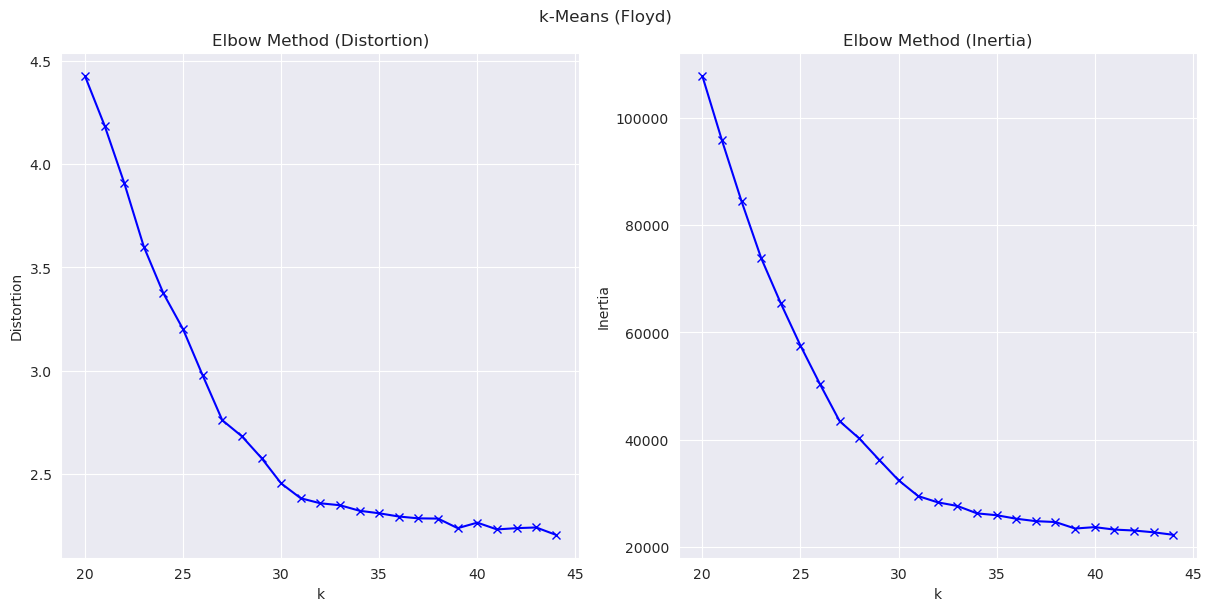

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Floyd)");

In [14]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{0: (0.9883720930232558, 'clinical research'),
 1: (0.989501312335958, 'production process controls'),
 2: (0.9908256880733946, 'labeling and packaging operations'),
 3: (0.9733333333333334, 'data management'),
 4: (1.0, 'non clinical research'),
 5: (0.6666666666666666, 'quality management'),
 6: (0.3333333333333333, 'production process controls'),
 7: (0.9781021897810219, 'material and product controls'),
 8: (1.0, 'udi and serialization'),
 9: (1.0, 'purchasing controls'),
 10: (0.989010989010989, 'design controls'),
 11: (0.963855421686747, 'documentation management'),
 12: (1.0, 'vigilance'),
 13: (1.0, 'laboratory controls'),
 14: (1.0, 'stability programs'),
 15: (0.7142857142857143, 'training'),
 16: (0.9622641509433962, 'samd'),
 17: (0.9833333333333333, 'qrb'),
 18: (1.0, 'controled substances'),
 19: (0.9454545454545454, 'audit inspection'),
 20: (0.9583333333333334, 'vmp'),
 21: (0.9791666666666666, 'medical device post market surveillance'),
 22: (0.9761904761904762, 'labo

In [15]:
missing, multiple = sanity_check(scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'capa',
 'facilities',
 'handling',
 'nc',
 'packaging operations',
 'qsmr',
 'rca',
 'storage and distribution',
 'utilities and equipment'}


Multiple:
[('purchasing controls', 2),
 ('risk management', 2),
 ('labeling and packaging operations', 2),
 ('production process controls', 3),
 ('quality management', 2),
 ('laboratory controls', 2),
 ('training', 2),
 ('product returns', 2)]


In [16]:
pp.pprint(scores_deep)

{0: {'clinical research': 0.9883720930232558,
     'documentation management': 0.003875968992248062},
 1: {'labeling and packaging operations': 0.0026246719160104987,
     'production process controls': 0.989501312335958},
 2: {'labeling and packaging operations': 0.9908256880733946,
     'production process controls': 0.0045871559633027525},
 3: {'csv': 0.013333333333333334, 'data management': 0.9733333333333334},
 4: {-1: 0.0, 'non clinical research': 1.0},
 5: {'quality management': 0.6666666666666666,
     'quality planning': 0.3333333333333333},
 6: {'process & packaging validation': 0.3333333333333333,
     'production process controls': 0.3333333333333333},
 7: {'identification and traceability': 0.0072992700729927005,
     'material and product controls': 0.9781021897810219},
 8: {-1: 0.0, 'udi and serialization': 1.0},
 9: {-1: 0.0, 'purchasing controls': 1.0},
 10: {'design controls': 0.989010989010989,
      'laboratory controls': 0.01098901098901099},
 11: {'documentation m

In [17]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET]
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

In [18]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



k-means (Elkan)

In [19]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(len(features.mlb.classes_)//2, len(features.mlb.classes_)+5)

for k in tqdm(K):
    # Building and fitting the model
    kmeans = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
    kmeanModel = kmeans.fit(embeddings)
    distortions.append(
        sum(np.min(
            cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
            axis=1
        )) / embeddings.shape[0]
    )
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = sum(np.min(
        cdist(embeddings, kmeanModel.cluster_centers_, 'euclidean'),
        axis=1
    )) / embeddings.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|██████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]


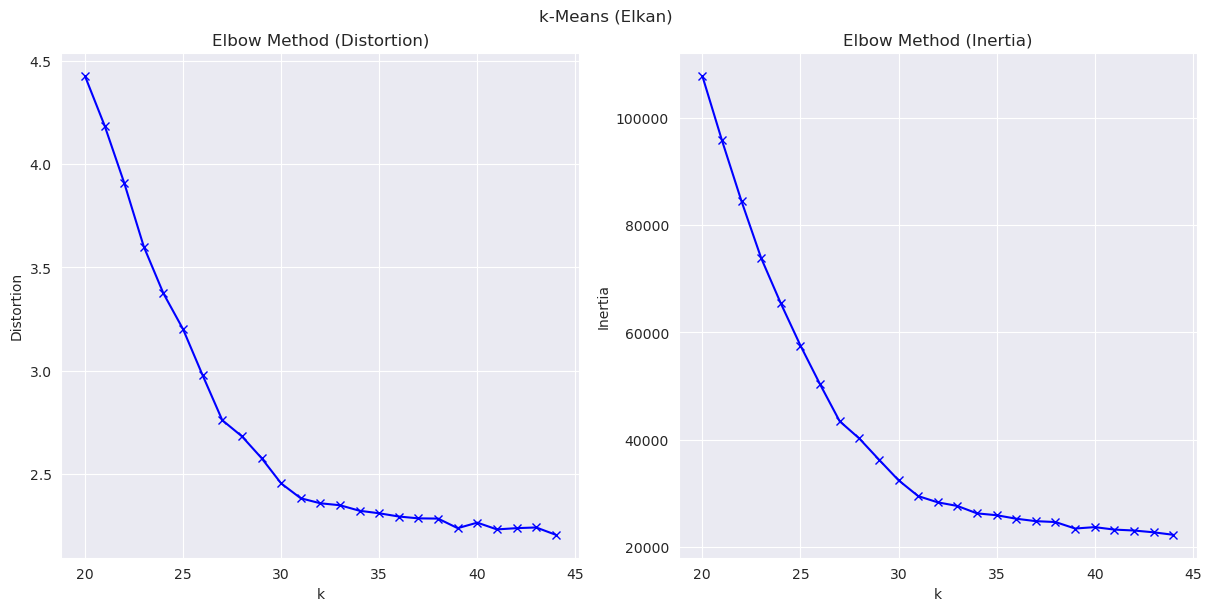

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(K, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(K, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("k-Means (Elkan)");

In [21]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{0: (0.9883720930232558, 'clinical research'),
 1: (0.989501312335958, 'production process controls'),
 2: (0.9908256880733946, 'labeling and packaging operations'),
 3: (0.9733333333333334, 'data management'),
 4: (1.0, 'non clinical research'),
 5: (0.6666666666666666, 'quality management'),
 6: (0.3333333333333333, 'production process controls'),
 7: (0.9781021897810219, 'material and product controls'),
 8: (1.0, 'udi and serialization'),
 9: (1.0, 'purchasing controls'),
 10: (0.989010989010989, 'design controls'),
 11: (0.963855421686747, 'documentation management'),
 12: (1.0, 'vigilance'),
 13: (1.0, 'laboratory controls'),
 14: (1.0, 'stability programs'),
 15: (0.7142857142857143, 'training'),
 16: (0.9622641509433962, 'samd'),
 17: (0.9833333333333333, 'qrb'),
 18: (1.0, 'controled substances'),
 19: (0.9454545454545454, 'audit inspection'),
 20: (0.9583333333333334, 'vmp'),
 21: (0.9791666666666666, 'medical device post market surveillance'),
 22: (0.9761904761904762, 'labo

In [22]:
missing, multiple = sanity_check(scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'capa',
 'facilities',
 'handling',
 'nc',
 'packaging operations',
 'qsmr',
 'rca',
 'storage and distribution',
 'utilities and equipment'}


Multiple:
[('purchasing controls', 2),
 ('risk management', 2),
 ('labeling and packaging operations', 2),
 ('production process controls', 3),
 ('quality management', 2),
 ('laboratory controls', 2),
 ('training', 2),
 ('product returns', 2)]


In [23]:
pp.pprint(scores_deep)

{0: {'clinical research': 0.9883720930232558,
     'documentation management': 0.003875968992248062},
 1: {'labeling and packaging operations': 0.0026246719160104987,
     'production process controls': 0.989501312335958},
 2: {'labeling and packaging operations': 0.9908256880733946,
     'production process controls': 0.0045871559633027525},
 3: {'csv': 0.013333333333333334, 'data management': 0.9733333333333334},
 4: {-1: 0.0, 'non clinical research': 1.0},
 5: {'quality management': 0.6666666666666666,
     'quality planning': 0.3333333333333333},
 6: {'process & packaging validation': 0.3333333333333333,
     'production process controls': 0.3333333333333333},
 7: {'identification and traceability': 0.0072992700729927005,
     'material and product controls': 0.9781021897810219},
 8: {-1: 0.0, 'udi and serialization': 1.0},
 9: {-1: 0.0, 'purchasing controls': 1.0},
 10: {'design controls': 0.989010989010989,
      'laboratory controls': 0.01098901098901099},
 11: {'documentation m

In [24]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

In [25]:
k = len(features.mlb.classes_)
clustering_method = KMeans(n_clusters=k, random_state=0, algorithm="elkan")
clusters = clustering_method.fit(embeddings)

dim_reduction_method = \
    umap.UMAP(
        n_neighbors=15,
        n_components=2,
        metric="cosine",
        min_dist=0.0
    )
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="k-Means & UMAP"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Hierarchical Clustering (HDBSCAN)

This algorithm figures out the number of clusters on its own

In [26]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = PCA(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

scores, scores_deep = compute_purity(embeddings_df)
pp.pprint(scores)

{-1: (0.17142857142857143, 'quality planning'),
 0: (1.0, 'stability programs'),
 1: (1.0, 'controled substances'),
 2: (1.0, 'calibration'),
 3: (0.9622641509433962, 'samd'),
 4: (0.9883720930232558, 'clinical research'),
 5: (0.9882352941176471, 'laboratory controls'),
 6: (1.0, 'non clinical research'),
 7: (0.9375, 'identification and traceability'),
 8: (0.9773755656108597, 'labeling and packaging operations'),
 9: (1.0, 'udi and serialization'),
 10: (0.989010989010989, 'design controls'),
 11: (1.0, 'vigilance'),
 12: (1.0, 'medical device post market surveillance'),
 13: (0.9833333333333333, 'qrb'),
 14: (1.0, 'csv'),
 15: (0.9454545454545454, 'audit inspection'),
 16: (0.9921052631578947, 'production process controls'),
 17: (1.0, 'product returns'),
 18: (1.0, 'new product quality planning'),
 19: (0.9712230215827338, 'material and product controls'),
 20: (1.0, 'change controls'),
 21: (1.0, 'purchasing controls'),
 22: (0.9743589743589743, 'process & packaging validation'),

Unclustered Samples

In [27]:
f"{sum(embeddings_df[CLUSTER] == -1) / len(embeddings_df) * 100:.3}%"

'2.51%'

In [28]:
missing, multiple = sanity_check(scores)
print("Missing:")
pp.pprint(missing)
print("\n\nMultiple:")
pp.pprint(multiple)

Missing:
{'capa',
 'facilities',
 'handling',
 'nc',
 'packaging operations',
 'qsmr',
 'rca',
 'storage and distribution',
 'utilities and equipment'}


Multiple:
[]


In [32]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "capa"].shape

(0, 551)

In [33]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "facilities"].shape

(0, 551)

In [34]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "handling"].shape

(0, 551)

In [35]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "nc"].shape

(0, 551)

In [38]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "rca"].shape

(0, 551)

In [37]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "qsmr"].shape

(3, 551)

In [41]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "rca"].shape

(0, 551)

In [39]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "storage and distribution"].shape

(0, 551)

In [40]:
df_features[df_features[TARGET].apply(lambda x: x[0]) == "utilities and equipment"].shape

(0, 551)

In [29]:
pp.pprint(scores_deep)

{-1: {'production process controls': 0.11428571428571428,
      'quality planning': 0.17142857142857143},
 0: {-1: 0.0, 'stability programs': 1.0},
 1: {-1: 0.0, 'controled substances': 1.0},
 2: {-1: 0.0, 'calibration': 1.0},
 3: {'md product cybersecurity': 0.018867924528301886,
     'samd': 0.9622641509433962},
 4: {'clinical research': 0.9883720930232558,
     'documentation management': 0.003875968992248062},
 5: {'laboratory controls': 0.9882352941176471,
     'production process controls': 0.011764705882352941},
 6: {-1: 0.0, 'non clinical research': 1.0},
 7: {'identification and traceability': 0.9375,
     'labeling and packaging operations': 0.0625},
 8: {'labeling and packaging operations': 0.9773755656108597,
     'production process controls': 0.00904977375565611},
 9: {-1: 0.0, 'udi and serialization': 1.0},
 10: {'design controls': 0.989010989010989,
      'laboratory controls': 0.01098901098901099},
 11: {-1: 0.0, 'vigilance': 1.0},
 12: {-1: 0.0, 'medical device post m

In [30]:
fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & PCA"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

In [31]:
clustering_method = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom"
)
clusters = clustering_method.fit(embeddings)

dim_reduction_method = TSNE(n_components=2)
embeddings_reduced = dim_reduction_method.fit_transform(embeddings)

embeddings_df = pd.DataFrame(embeddings, columns=EMBEDDINGS)
embeddings_df["x"] = embeddings_reduced[:,0]
embeddings_df["y"] = embeddings_reduced[:,1]
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET_NUMERIC] = y_true
embeddings_df[TARGET] = embeddings_df[TARGET_NUMERIC].apply(lambda x: features.mlb.classes_[x])

fig = px.scatter(
    embeddings_df,
    y="y",
    x="x",
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[TARGET],
    title="HDBSCAN & TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show();

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/vtyagi/miniconda3/envs/capstone/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

